# Intro
 - 비지도학습: Target Att가 없이 데이터를 학습하는 것. 이는 Feature Engineering측면에서 Feature Discovery로 작용할 수 있다.
 - Clustering: Data point를 몇개의 집단에 할당하는 것
   - Feature Engineering에 활용: 동일 날씨 지역 mapping, 고객 그룹화 등 --> 이러한 그룹을 feature에 추가하는 것은 모델 학습에 도움을 줄 수 있다.

### 이는 각각 1차원과 2차원에서 Clustering을 의미
 - 이러한 Cluster는 Categorical하며, Labelencoding 보다는 onehotEncoding으로 각 군집을 나타내는 것이 바람직하다.
 - 클러스터링은 복잡한 관계를 간단하게 나눠주는 기능!
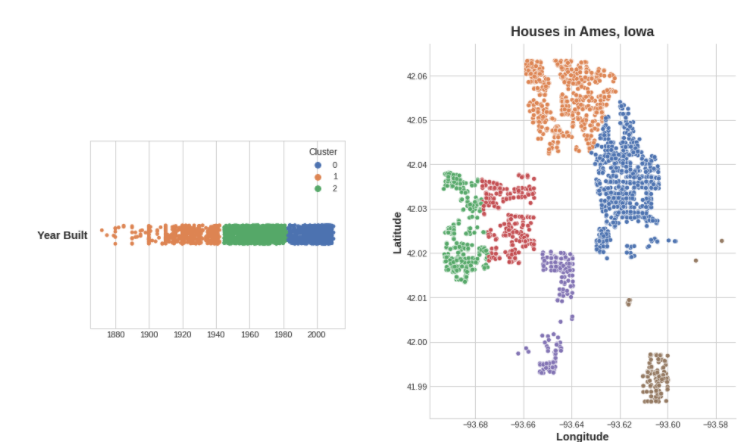

### Sale Price vs YearBulit를 선형회귀 모델링 시도
 - 전체에 대해서 시도하면 하나의 직선으로 나타낼 수 없어 underfitting이 발생한다.
 - 그러나 각각 나눠서 실시한다면, 각 클러스터에서 선형회귀가 전자보다 적절하게 적합된 것을 볼 수 있다.
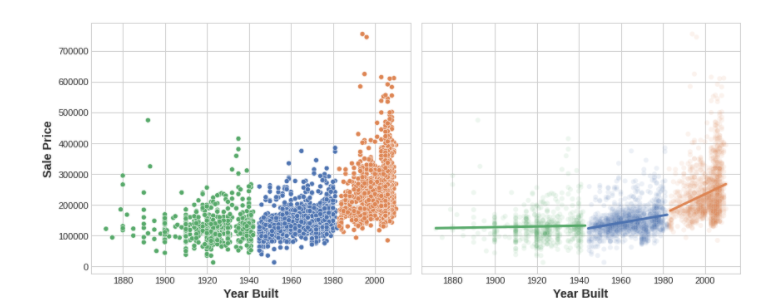

# K-means 알고리즘을 활용한 Clustering
 - 중심점과 각 데이터 포인트 간 유클리디안 거리 산정. 가장 가까운 거리의 중심점에 해당 데이터 포인트를 할당한다.
 -  Voronoi tessallation: 해당 데이터에서 K-mean 결과 군집에 대한 경계선을 산정 후, 새로운 데이터가 들어왔을 때 좌표에 따라 할당되는 군집을 확인할 수 있게 해주는 다이어그램
 - K-means는 스케일링에 영향을 크게 받기에, 스케일링을 해주자!
 
### sklearn을 활용한 K-means
 - 중요 파라미터
   - n_cluster: 군집의 개수 (핵심)
   - max_iter: 만약 중심점이 변화가 수렴하지 않고 계속 변할 시 최대 몇번의 시도까지 해볼 것인가?
   - n_iter: 랜덤한 초기 중심점을 몇번 바꾸며 실행할 것인가? (최종 output은 가장 최적의 것을 뱉는다.)
   
 - 데이터의 수가 많다면 max_iter를 충분히 크게, 데이터셋이 복잡하다면, n_iter를 최대한 크게 가져가자.
  (데이터 수가 많은데 n_iter가 크면 엄청 오래걸리겠지?? 그러니까 아닌듯?)

# Example

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv("./data/housing.csv")
X = df.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [3]:
# 위도, 경도, 소득수준으로 Clustering을 하여 파생변수 생성
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,2
1,8.3014,37.86,-122.22,2
2,7.2574,37.85,-122.24,2
3,5.6431,37.85,-122.25,2
4,3.8462,37.85,-122.25,0


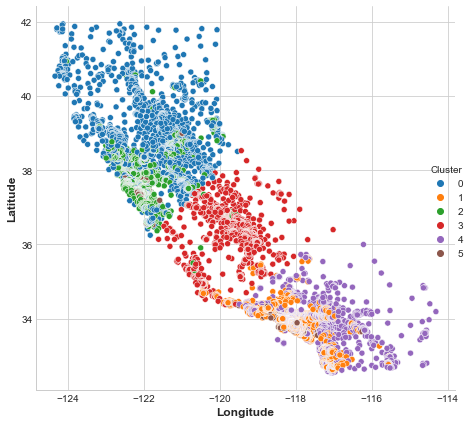

In [4]:
sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

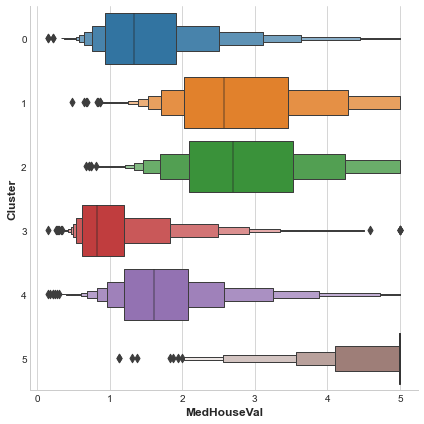

In [6]:
# 최종 모델의 Target Value인 MedHouseVal의 각 군집에서 Box plot을 Check
# 꽤나 유의미한 차이를 보이는 것으로 보아, 이는 유의미한 파생변수라고 해석 가능
X["MedHouseVal"] = df["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

# 실습

In [13]:
# Setup feedback system
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("./data/ames.csv")

In [14]:
X = df.copy()
y = X.pop("SalePrice")


# YOUR CODE HERE: Define a list of the features to be used for the clustering
features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)


# YOUR CODE HERE: Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)
score_dataset(X, y)

0.1425257903378395

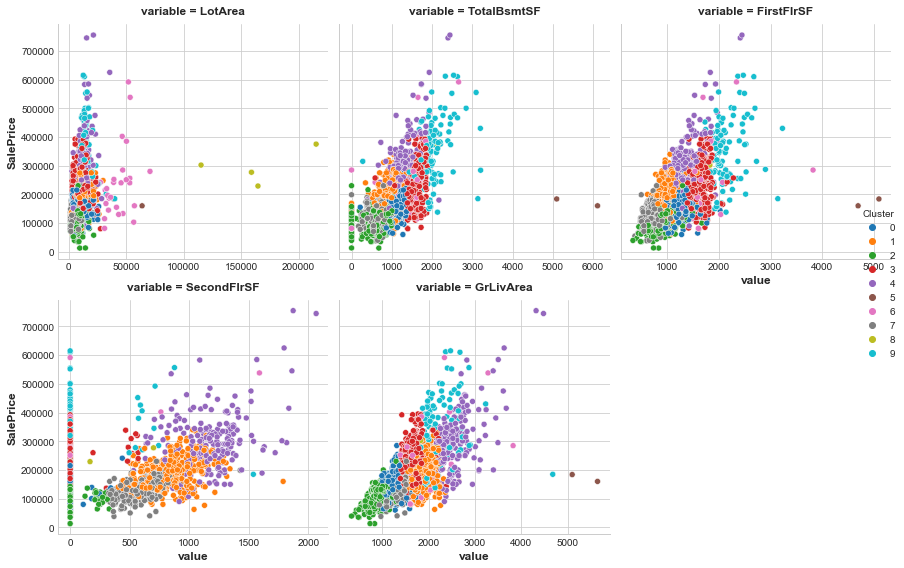

In [15]:
# 클러스터 시각화
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3, # aspect: 가로 길이인듯?  //  col_wrap: 열당 최대개수
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);

In [16]:
# Cluster의 중심점까지 거리를 Feature로 대입 --> 효과가 있다!
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)


# YOUR CODE HERE: Create the cluster-distance features using `fit_transform`
X_cd =  kmeans.fit_transform(X_scaled)


# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

score_dataset(X, y)

0.13965653367684064